In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from sklearn.linear_model import LinearRegression
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dreal, dcomplex

# Import dataset

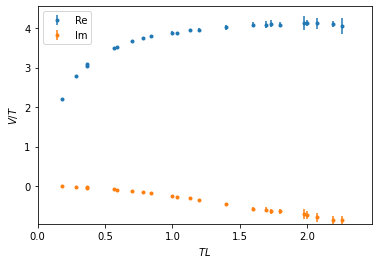

In [2]:
dataset = AdSBHDataset(file='lattice.txt')
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

Right now we can't solve for the `curve` for that high $T L$ so we'll drop some data points.

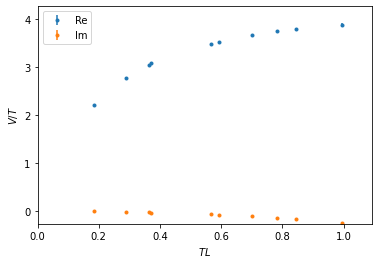

In [3]:
dataset.V = dataset.V[dataset.L < 1]
dataset.sigma = dataset.sigma[dataset.L < 1]
dataset.L = dataset.L[dataset.L < 1]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

# Initialize model

In [12]:
model = AdSBHNet(N=2, std=0.5)

It is advisable to try choosing reasonable initial values for `logcoef` and `shift` to help learning.

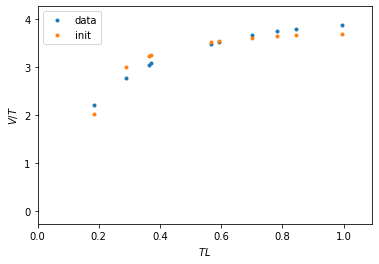

In [13]:
with torch.no_grad():
    # Note that V_pred is proportional to `coef`.
    x = model(dataset.L).real.reshape(-1, 1) / model.logcoef.exp()
    x = x.numpy()
    y = dataset.V.real.numpy()
    fit = LinearRegression().fit(x, y)
    # Set `logcoef` and `shift` to the linear fit values
    model.logcoef = nn.Parameter(torch.tensor(fit.coef_, dtype=dreal).log())
    model.shift = nn.Parameter(torch.tensor(fit.intercept_, dtype=dreal))
plt.plot(dataset.L, y, '.', label='data')
plt.plot(dataset.L, fit.coef_ * x + fit.intercept_, '.', label='init')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

# Training

In [14]:
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
epochs = 100
a_vals, b_vals, coef_vals, shift_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()], [model.logcoef.exp().item()], [model.shift.item()]

z = np.linspace(0, 0.95, 50)
fzInit = model.eval_f(z).detach().numpy()
gzInit = model.eval_g(z).detach().numpy()
fz0 = 1-z**4
gz0 = 1/fz0

try:
    for epoch in range(epochs):
        for L, V, sigma in loader:
            optimizer.zero_grad()
            V_pred = model(L)
            V_diff = V_pred + model.shift - V
            loss = torch.mean(V_diff.real**2 / sigma.real) + torch.mean(V_diff.imag**2 / sigma.imag)
            loss.backward()
            a_vals.append(model.a.detach().numpy().copy())
            b_vals.append(model.b.detach().numpy().copy())
            coef_vals.append(model.logcoef.exp().item())
            shift_vals.append(model.shift.item())
            optimizer.step()
        print(f'epoch={epoch:2d}, loss={loss.item():0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

fz = model.eval_f(z).detach().numpy()
gz = model.eval_g(z).detach().numpy()

epoch= 0, loss=145.020711
epoch= 1, loss=92.342830
epoch= 2, loss=72.663291
epoch= 3, loss=63.372712
epoch= 4, loss=56.953667
epoch= 5, loss=51.932343
epoch= 6, loss=47.129799
epoch= 7, loss=41.916710
epoch= 8, loss=36.490958
epoch= 9, loss=31.448173
epoch=10, loss=27.302486
epoch=11, loss=24.214828
epoch=12, loss=22.000313
epoch=13, loss=20.287794
epoch=14, loss=18.678439
epoch=15, loss=16.881135
epoch=16, loss=14.821026
epoch=17, loss=12.651278
epoch=18, loss=10.637775
epoch=19, loss=8.996776
epoch=20, loss=7.792168
epoch=21, loss=6.943479
epoch=22, loss=6.308788
epoch=23, loss=5.761625
epoch=24, loss=5.227527
epoch=25, loss=4.691468
epoch=26, loss=4.182703
epoch=27, loss=3.743370
epoch=28, loss=3.400365
epoch=29, loss=3.152999
epoch=30, loss=2.973299
epoch=31, loss=2.818696
epoch=32, loss=2.656645
epoch=33, loss=2.482986
epoch=34, loss=2.315608
epoch=35, loss=2.171777
epoch=36, loss=2.051983
epoch=37, loss=1.941152
epoch=38, loss=1.822646
epoch=39, loss=1.692591
epoch=40, loss=1.561

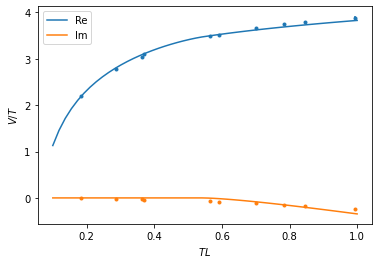

In [15]:
with torch.no_grad():
    L_grid = torch.linspace(0.1, 1.0, 50)
    V_grid = model(L_grid) + model.shift
plt.plot(L_grid, V_grid.real, label='Re')
plt.plot(L_grid, V_grid.imag, label='Im')
plt.errorbar(dataset.L, dataset.V.real, yerr=dataset.sigma.real, fmt='.', c='C0')
plt.errorbar(dataset.L, dataset.V.imag, yerr=dataset.sigma.imag, fmt='.', c='C1')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.legend();

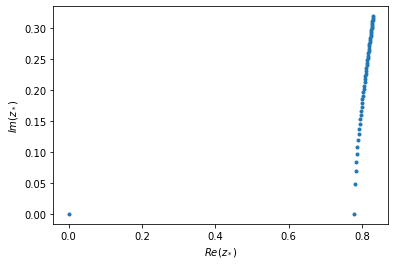

In [16]:
plt.plot([np.real(x) for x in model.curve_zs], [np.imag(x) for x in model.curve_zs], '.')
plt.xlabel(f'$Re(z_*)$')
plt.ylabel(f'$Im(z_*)$');

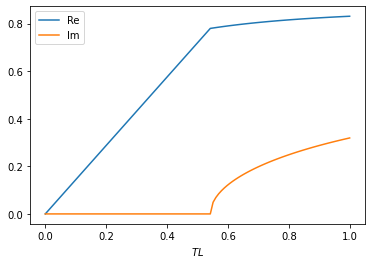

In [17]:
plt.plot(model.curve_L, [np.real(x) for x in model.curve_zs], label='Re')
plt.plot(model.curve_L, [np.imag(x) for x in model.curve_zs], label='Im')
plt.xlabel(f'$T L$')
plt.legend();

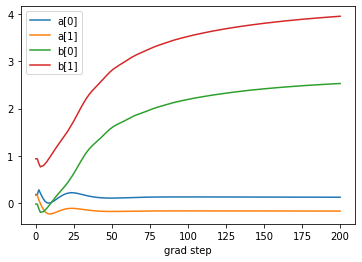

In [18]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.xlabel('grad step')
plt.legend();

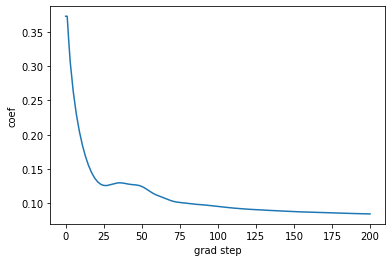

In [19]:
plt.plot(coef_vals, label='coef')
plt.xlabel('grad step')
plt.ylabel('coef');

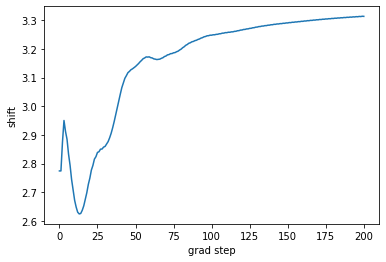

In [20]:
plt.plot(shift_vals, label='shift')
plt.xlabel('grad step')
plt.ylabel('shift');

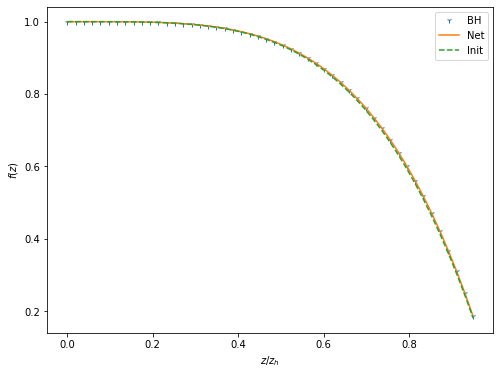

In [21]:
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$f(z)$')
plt.legend();

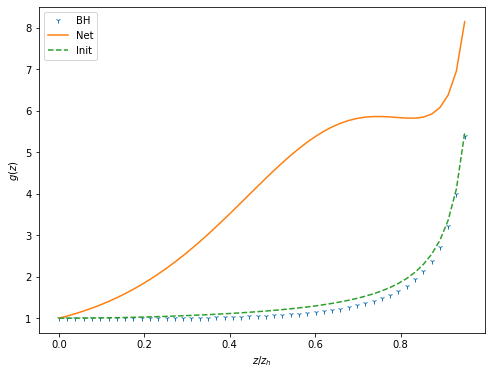

In [22]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$g(z)$')
plt.legend();

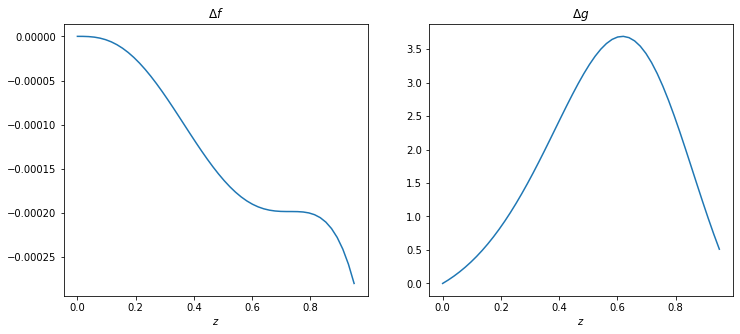

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(z, (fz-fz0)/fz0)
axs[0].set_title(f'$\Delta f$')
axs[0].set_xlabel(f'$z$')
axs[1].plot(z, (gz-gz0)/gz0)
axs[1].set_title(f'$\Delta g$')
axs[1].set_xlabel(f'$z$');